In [1]:
from sklearn.externals import joblib
from ctapipe.utils import get_dataset_path
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
import reco.calib_dl0_to_dl1 as calib
import reco.reco_dl1_to_dl2 as reco
import reco.plot_dl2 as lstplot

/Users/thomasvuillaume/anaconda/envs/cta-dev/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Import a simtelarray file with data
datafile = get_dataset_path('gamma_test_large.simtel.gz')

/Users/thomasvuillaume/Library/Caches/Python-Eggs/ctapipe_extra-0.2.14-py3.6.egg-tmp/ctapipe_resources/gamma_test_large.simtel.gz


In [3]:
#Select LST1 events from the file, calibrate them, extract hillas and timing parameters.
#DL0 -> DL1 

data = calib.get_events(datafile,False,True)

EVENT_ID:  153614 TELS:  {1} MC Energy: 0.010249877348542213 TeV


../reco/calib_dl0_to_dl1.py:182: RuntimeWarning: invalid value encountered in log10
  log10pixelHGsignal[str(geom)].extend(np.log10(signals))


In [4]:
#Take a look at the parameters extracted from the simtelarray file:
print(data.keys())

Index(['obs_id', 'event_id', 'mc_energy', 'mc_alt', 'mc_az', 'mc_core_x',
       'mc_core_y', 'mc_h_first_int', 'mc_type', 'gps_time', 'width', 'length',
       'w/l', 'phi', 'psi', 'r', 'x', 'y', 'intensity', 'skewness', 'kurtosis',
       'mc_alt_tel', 'mc_az_tel', 'impact', 'mc_x_max', 'time_gradient',
       'intercept', 'src_x', 'src_y', 'disp', 'hadroness'],
      dtype='object')


Text(0.5,0,'$log_{10} mc_energy$ (MeV)')

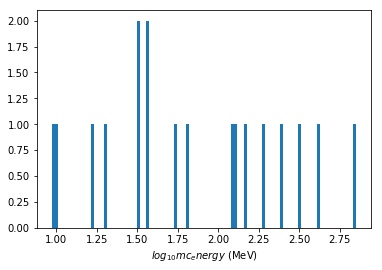

In [5]:
#We can plot some distributions:
plt.hist(data['mc_energy'],bins=100) #Log10(Energy) in MeV
plt.xlabel('$log_{10} mc_energy$ (MeV)')

Text(0.5,0,'$log_{10} intensity$')

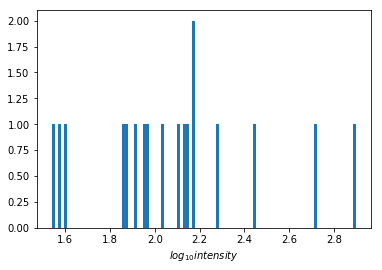

In [6]:
plt.hist(data['intensity'],bins=100) #Log10(intensity(size))
plt.xlabel('$log_{10} intensity$')

Text(0.5,0,'width (º)')

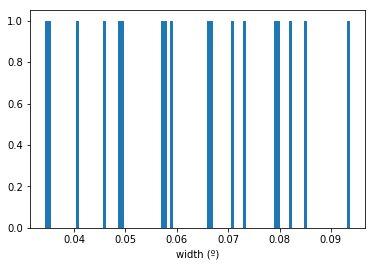

In [7]:
plt.hist(data['width'],bins=100) #Width in deg.
plt.xlabel('width (º)')

Text(0.5,0,'length (º)')

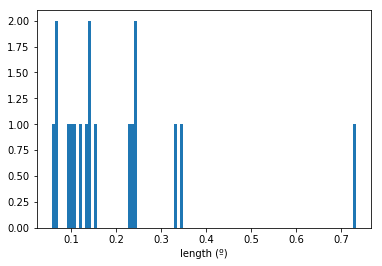

In [8]:
plt.hist(data['length'],bins=100) #Length in deg. 
plt.xlabel('length (º)')

Text(0,0.5,'y (m)')

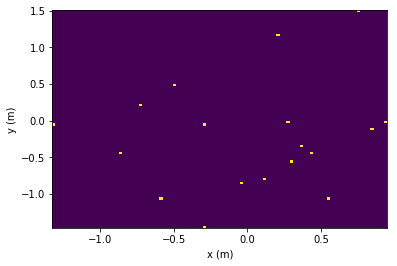

In [9]:
#See the source position: Point gammas or diffuse gammas? (camera coordinates)
plt.hist2d(data['src_x'],data['src_y'],bins=100)
plt.xlabel('x (m)')
plt.ylabel('y (m)')

Text(0,0.5,'y (m)')

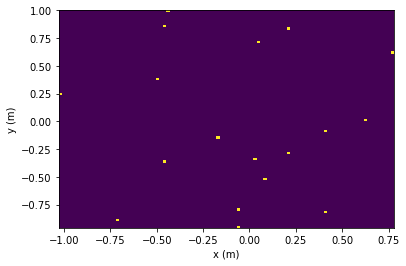

In [10]:
#Position of the hillas ellipse center of gravity (camera coordinates)
plt.hist2d(data['x'],data['y'],bins=100)
plt.xlabel('x (m)')
plt.ylabel('y (m)')

In [11]:
#Let's train the Random Forests for Reconstruction
#We must have two files, one with dl1 gamma events and other with dl1 proton events
PATH_EVENTS = "/scratch/bernardos/LST1/Events/"
gammafile = PATH_EVENTS+"gamma_events_point.hdf5"
protonfile = PATH_EVENTS+"proton_events.hdf5"
print(gammafile,protonfile)

/scratch/bernardos/LST1/Events/gamma_events_point.hdf5 /scratch/bernardos/LST1/Events/proton_events.hdf5


In [12]:
#Define the features to train the RF:
features = ['intensity',                                                                                  
                'time_gradient',                                                                              
                'width',                                                                                      
                'length',                                                                                     
                'w/l',                                                                                        
                'phi',                                                                                        
                'psi']
print(features)

['intensity', 'time_gradient', 'width', 'length', 'w/l', 'phi', 'psi']


In [13]:
#Train three Random Forests:
#- Two Random Forests Regressors for Energy and disp_(source position) reconstruction
#- One Random Forest Classifier for gamma/hadron separation (uses results from previous RF as new features, e_rec, disp_rec)

RFreg_Energy,RFreg_disp_,RFcls_GH = reco.buildModels(gammafile,protonfile,features,False)

FileNotFoundError: File /scratch/bernardos/LST1/Events/gamma_events_point.hdf5 does not exist

In [37]:
#Now we have the trained RF that we can use to reconstruct our data into dl2 format:
data_dl2 = data
reco.ApplyModels(data,data_dl2,features,RFcls_GH,RFreg_Energy,RFreg_disp_)
print(data_dl2.keys())

Index(['obs_id', 'event_id', 'mc_energy', 'mcAlt', 'mc_az', 'mc_core_x', 'mc_core_y',
       'mcHfirst', 'mc_type', 'gps_time', 'width', 'length', 'w/l', 'phi', 'psi',
       'r', 'x', 'y', 'intensity', 'skewness', 'kurtosis', 'mcAlttel',
       'mc_az_tel', 'impact', 'mc_x_max', 'time_gradient', 'intercept', 'src_x',
       'src_y', 'disp', 'hadroness', 'e_rec', 'disp_rec', 'src_x_rec', 'src_y_rec',
       'hadro_rec'],
      dtype='object')


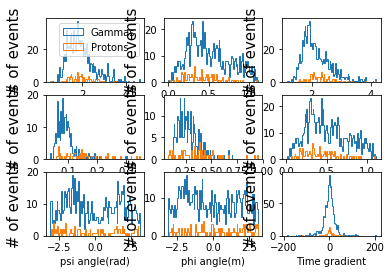

In [38]:
#Lets take a look to the results
lstplot.plot_features(data_dl2)

0.01933060164898719 0.6056633919429704


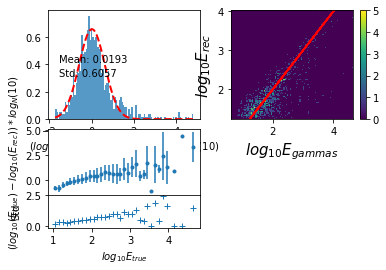

In [39]:
lstplot.plot_E(data_dl2)

0.05978073655669025 0.24232860117888574


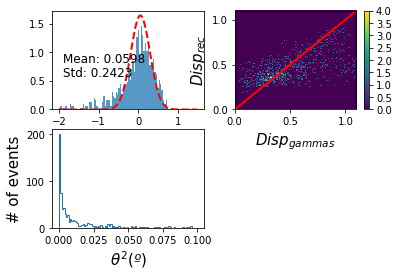

In [41]:
lstplot.plot_disp_(data_dl2)

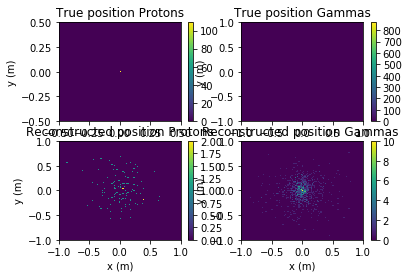

In [40]:
lstplot.plot_pos(data_dl2)

Text(0.5,0,'Hadroness')

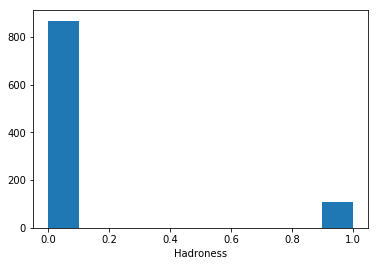

In [42]:
plt.hist(data_dl2['hadro_rec'])
plt.xlabel('Hadroness')

In [43]:
#We can apply a cut in energy and see the results again:
data_dl2 = data_dl2[data_dl2['e_rec']>2.699]

0.09917657580097941 0.4752955181407565


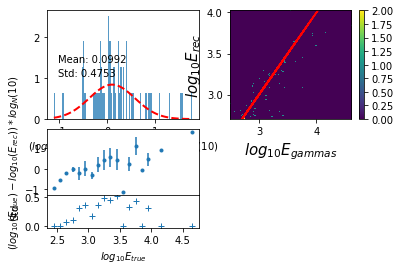

In [44]:
lstplot.plot_E(data_dl2)

0.0255947595899268 0.0984188680013846


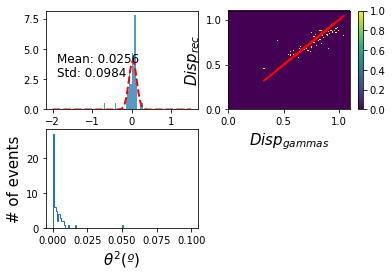

In [45]:
lstplot.plot_disp_(data_dl2)

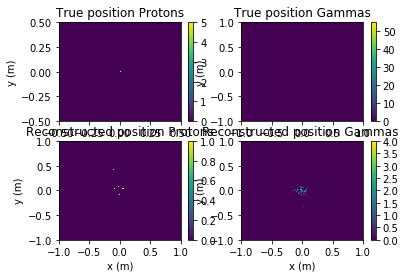

In [46]:
lstplot.plot_pos(data_dl2)

Text(0.5,0,'Hadroness')

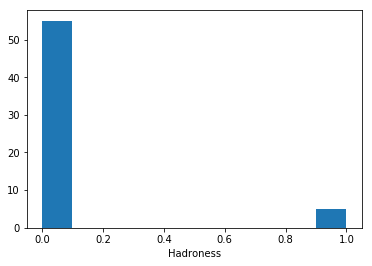

In [47]:
plt.hist(data_dl2['hadro_rec'])
plt.xlabel('Hadroness')